# Load Python packages

In [38]:
# Load packages
# Established packages
import os
import numpy as np
import pandas as pd
import geopandas as gp
import datetime
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import matplotlib.pyplot as plt
import zarr

# Custom package covid19model
from covid19model.models import models
from covid19model.data import model_parameters #, sciensano, google
from covid19model.visualization.output import population_status, infected, show_map, show_graphs
from covid19model.models.time_dependant_parameter_fncs import lockdown_func, mobility_update_func

# Moving average for visualisation
from covid19model.visualization.utils import moving_avg
from covid19model.models.utils import read_pops, read_coordinates_nis, initial_state

# Download function for complete calibration
# covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Spatial stratification
agg = 'arr'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load model parameter values
The model is supported by many parameters, which must be loaded into the model later on

In [39]:
# Interaction matrices
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = \
    model_parameters.get_interaction_matrices(spatial=agg)

# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg)
start_date = pd.to_datetime('2020-03-18')

# Add the social effect of the first lockdown
params.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': start_date})

# Add parameters for the daily update of mobility
params.update({'agg' : agg,
               'default_mobility' : None}) # mobility defaults to average mobility

# Add clearly distinct infectivity parameters for demonstration
beta_R = 0.0
beta_U = 0.0
beta_M = 0.035
params.update({'beta_R' : beta_R,
               'beta_U' : beta_U,
               'beta_M' : beta_M})

# Initialise model
The spatial model must have an initial condition

In [42]:
# Initial states
initE = initial_state(dist=81000, agg=agg, age=40, number=1000) # 1000 40-somethings dropped in Arlon
initial_states = {'S': initN, 'E': initE}

# Initiate model with initial states, defined parameters, and lockdown_func determining the evolution of Nc
model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                           {'Nc' : lockdown_func, 'place' : mobility_update_func}, spatial=agg)


end_date = pd.to_datetime('2020-05-15')
start_date = pd.to_datetime('2020-01-01')
out = model_wave1.sim(end_date, start_date=start_date)

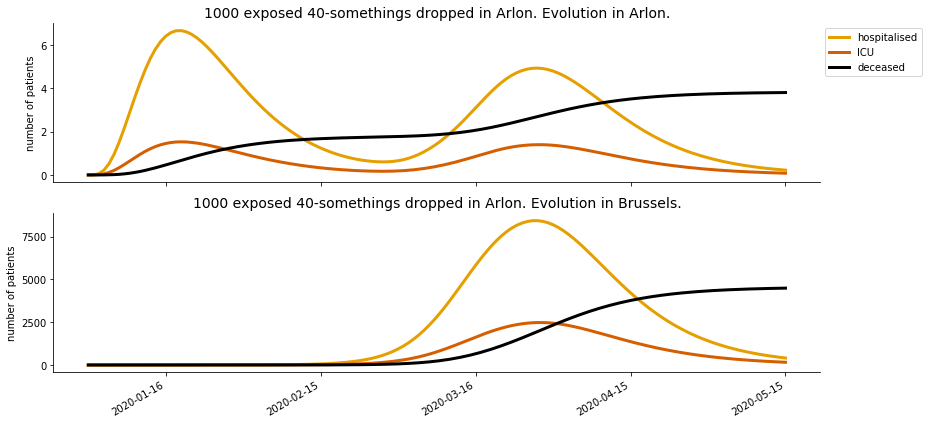

In [43]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(13,6))

infected(out.sel(place=81000), ax=ax1)
ax1.grid(False)
ax1.set_xlabel(None)
ax1.set_title("1000 exposed 40-somethings dropped in Arlon. Evolution in Arlon.", fontsize=14)

infected(out.sel(place=21000), ax=ax2)
ax2.grid(False)
ax2.set_xlabel(None)
ax2.set_title("1000 exposed 40-somethings dropped in Arlon. Evolution in Brussels.", fontsize=14)
ax2.get_legend().remove()

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
plt.savefig("test", dpi=200)

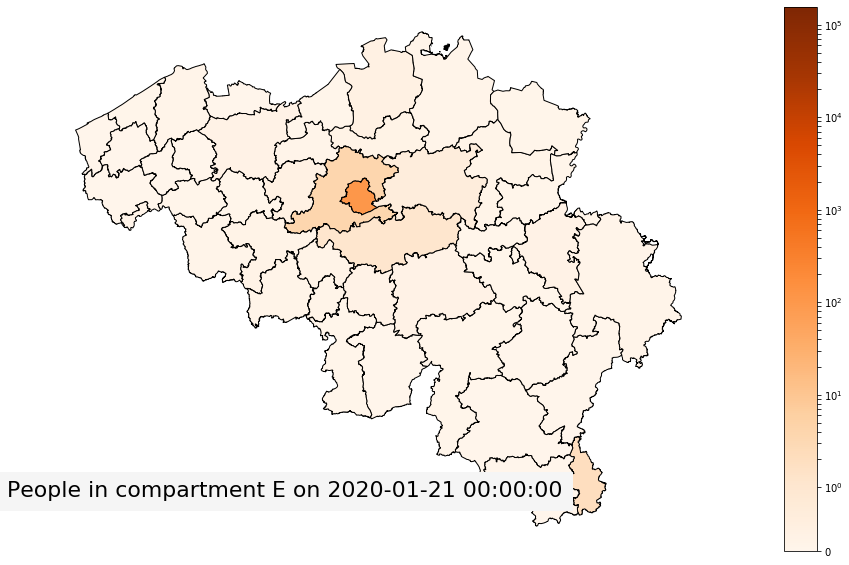

In [45]:
# Visualisation in geopandas
from covid19model.visualization.output import show_map
import geopandas as gp

shp_dir = "../../data/raw/GIS/shapefiles/BE/"
provinces = gp.read_file(shp_dir + "AD_4_Province.shp")
arrondissements = gp.read_file(shp_dir + "AD_3_District.shp")

for idx, day in enumerate(pd.date_range(start=start_date, end=end_date)[20:21]):
    print(f'working on day {day} ...', end='\r')
    fig = show_map(out, arrondissements, day=day, ts_graph=None, lin=False, rel=False)
#     plt.savefig(f'delete_this_directory/test_fig{idx}.png', dpi=200)
#     plt.close()

# Scratches